# Implementing a GAN over SVHN with Tensorflow
### By: Aldo Miranda Aguilar | CIC-IPN

## TensorFlow
TensorFlow (https://www.tensorflow.org/) is an open source software library for numerical computation using data flow graphs. Nodes in the graph represent mathematical operations, while the graph edges represent the multidimensional data arrays (tensors) communicated between them. The flexible architecture allows you to deploy computation to one or more CPUs or GPUs in a desktop, server, or mobile device with a single API. TensorFlow was originally developed by researchers and engineers working on the Google Brain Team within Google's Machine Intelligence research organization for the purposes of conducting machine learning and deep neural networks research, but the system is general enough to be applicable in a wide variety of other domains as well.

## Deep Convolutional Networks (CNNs / ConvNets)

Convolutional Neural Networks are very similar to ordinary Neural Networks in the sense that they are made up of neurons that have learnable weights and biases. Each neuron receives some inputs, performs a dot product and optionally follows it with a non-linearity. The whole network still expresses a single differentiable score function: from the raw image pixels on one end to class scores at the other. And they still have a loss function (e.g. SVM/Softmax) on the last (fully-connected) layer and all the tips/tricks we developed for learning regular Neural Networks still apply.

**ConvNet architectures make the explicit assumption that the inputs are images, which allows us to encode certain properties into the architecture. These then make the forward function more efficient to implement and vastly reduce the amount of parameters in the network.**

<img src="convnet.png" />

### Layers used to build ConvNets

As we described above, a simple ConvNet is a sequence of layers, and every layer of a ConvNet transforms one volume of activations to another through a differentiable function. We use three main types of layers to build ConvNet architectures: Convolutional Layer, Pooling Layer, and Fully-Connected Layer (exactly as seen in regular Neural Networks). We will stack these layers to form a full ConvNet architecture.

Example Architecture: Overview. We will go into more details below, but a simple ConvNet for CIFAR-10 classification could have the architecture [INPUT - CONV - RELU - POOL - FC]. In more detail:

* INPUT [32x32x3] will hold the raw pixel values of the image, in this case an image of width 32, height 32, and with three color channels R,G,B.
* CONV layer will compute the output of neurons that are connected to local regions in the input, each computing a dot product between their weights and a small region they are connected to in the input volume. This may result in volume such as [32x32x12] if we decided to use 12 filters.
* RELU layer will apply an elementwise activation function, such as the max(0,x)max(0,x) thresholding at zero. This leaves the size of the volume unchanged ([32x32x12]).
* POOL layer will perform a downsampling operation along the spatial dimensions (width, height), resulting in volume such as [16x16x12].
* FC (i.e. fully-connected) layer will compute the class scores, resulting in volume of size [1x1x10], where each of the 10 numbers correspond to a class score, such as among the 10 categories of CIFAR-10. As with ordinary Neural Networks and as the name implies, each neuron in this layer will be connected to all the numbers in the previous volume.

In this way, ConvNets transform the original image layer by layer from the original pixel values to the final class scores. Note that some layers contain parameters and other don’t. In particular, the CONV/FC layers perform transformations that are a function of not only the activations in the input volume, but also of the parameters (the weights and biases of the neurons). On the other hand, the RELU/POOL layers will implement a fixed function. The parameters in the CONV/FC layers will be trained with gradient descent so that the class scores that the ConvNet computes are consistent with the labels in the training set for each image.

In summary:

A ConvNet architecture is in the simplest case a list of Layers that transform the image volume into an output volume (e.g. holding the class scores)
* There are a few distinct types of Layers (e.g. CONV/FC/RELU/POOL are by far the most popular)
* Each Layer accepts an input 3D volume and transforms it to an output 3D volume through a differentiable function
* Each Layer may or may not have parameters (e.g. CONV/FC do, RELU/POOL don’t)
* Each Layer may or may not have additional hyperparameters (e.g. CONV/FC/POOL do, RELU doesn’t)

## Generative Adversarial Networks

<cite>“There are many interesting recent development in deep learning…The most important one, in my opinion, is adversarial training (also called GAN for Generative Adversarial Networks). This, and the variations that are now being proposed is the most interesting idea in the last 10 years in ML, in my opinion.”</cite> – **Yann LeCun**

There has been a large resurgence of interest in generative models recently. These are models that can learn to create data that is similar to data that we give them. The intuition behind this is that if we can get a model to write high-quality news articles for example, then it must have also learned a lot about news articles in general. Or in other words, the model should also have a good internal representation of news articles. We can then hopefully use this representation to help us with other related tasks, such as classifying news articles by topic.

Actually training models to create data like this is not easy, but in recent years a number of methods have started to work quite well. One such promising approach is using Generative Adversarial Networks (GANs).

### Discriminative vs. Generative models

Before looking at GANs, let’s briefly review the difference between generative and discriminative models:

* A discriminative model learns a function that maps the input data $(x)$ to some desired output class label $(y)$. In probabilistic terms, they directly learn the conditional distribution $P(y | x)$.
* A generative model tries to learn the joint probability of the input data and labels simultaneously, i.e. $P(x,y)$. This can be converted to $P(y | x)$ for classification via Bayes rule, but the generative ability could be used for something else as well, such as creating likely new $(x, y)$ samples.

Both types of models are useful, but generative models have one interesting advantage over discriminative models – they have the potential to understand and explain the underlying structure of the input data even when there are no labels. This is very desirable when working on data modelling problems in the real world, as unlabelled data is of course abundant, but getting labelled data is often expensive at best and impractical at worst.

GANs are an interesting idea that were first introduced in 2014 by a group of researchers at the University of Montreal lead by Ian Goodfellow (now at OpenAI). The main idea behind a GAN is to have two competing neural network models. One takes noise as input and generates samples (and so is called the generator). The other model (called the discriminator) receives samples from both the generator and the training data, and has to be able to distinguish between the two sources. These two networks play a continuous game, where the generator is learning to produce more and more realistic samples, and the discriminator is learning to get better and better at distinguishing generated data from real data. These two networks are trained simultaneously, and the hope is that the competition will drive the generated samples to be indistinguishable from real data.

<img src="ganmodel.png" />

The analogy that is often used here is that the generator is like a forger trying to produce some counterfeit material, and the discriminator is like the police trying to detect the forged items. This setup may also seem somewhat reminiscent of reinforcement learning, where the generator is receiving a reward signal from the discriminator letting it know whether the generated data is accurate or not. The key difference with GANs however is that we can backpropagate gradient information from the discriminator back to the generator network, so the generator knows how to adapt its parameters in order to produce output data that can fool the discriminator.

So far GANs have been primarily applied to modelling natural images. They are now producing excellent results in image generation tasks, generating images that are significantly sharper than those trained using other leading generative methods based on maximum likelihood training objectives.

### Python imports

In [4]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [3]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

### Downloading the dataset

In [2]:
!mkdir data

mkdir: data: File exists


In [5]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

### Loading dataset

In [6]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

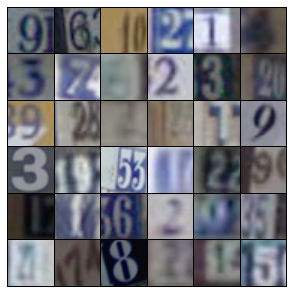

In [7]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

### Data handling objects

In [8]:
def scale(x, feature_range=(-1, 1)):
    x = ((x - x.min())/(255 - x.min()))
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [9]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y


In [10]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    return inputs_real, inputs_z

### Generator NN

Here you'll build the generator network. The input will be our noise vector z as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.
What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU. Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3.

In [11]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, output_dim, 5, strides=2, padding='same')
        # 32x32x3 now
        
        out = tf.tanh(logits)
        
        return out

### Discriminator NN

Here you'll find the discriminator. This is basically just a convolutional classifier. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers it's convenient to start with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.
You'll also want to use batch normalization with tf.layers.batch_normalization on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU.
Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set training to True.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the training parameter appropriately.

In [12]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Layer sizes
        # 32x32x3 
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

In [13]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

In [14]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

In [15]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=0.2)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

In [16]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

In [17]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1

                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})

                if steps % print_every == 0:
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

In [30]:
show_graph(tf.get_default_graph().as_graph_def())

### Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. 

In [26]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.0002
batch_size = 128
epochs = 25
alpha = 0.2
beta1 = 0.5

# Start Training
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

### Training

In [ ]:
dataset = Dataset(trainset, testset)

losses, samples = train(net, dataset, epochs, batch_size, figsize=(10,5))

In [2]:
import IPython.display as ipyd
ipyd.Image(url='anim.gif')

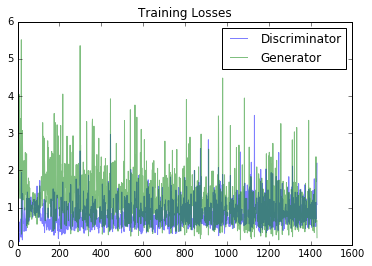

In [19]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()